In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import FuncFormatter
import pandas as pd
import networkx as nx
import pickle
import warnings
from scipy.stats import ttest_ind

#### House

In [3]:
with open('./pickles/HouseCongressToIndexDict.pickle', 'rb') as f:
	house_congress_to_index_dict = pickle.load(f)

/content/drive/MyDrive/RESEARCH


Half life 24 months

In [5]:
with open("./pickles/FailHouse24HalfLife.npy", "rb") as f:
	cum_adj_fail_house_24hl = np.load(f, allow_pickle=True)
	party_fail_house_24hl_total = np.load(f, allow_pickle=True)
	fail_house_avg_bill_24h = pd.read_pickle(f)
	fail_house_max_bill_24h = pd.read_pickle(f)

/content/drive/MyDrive/RESEARCH


Half life 12 months

In [6]:
with open("./pickles/FailHouse12HalfLife.npy", "rb") as f:
	cum_adj_fail_house_12hl = np.load(f, allow_pickle=True)
	party_fail_house_12hl_total = np.load(f, allow_pickle=True)
	fail_house_avg_bill_12h = pd.read_pickle(f)
	fail_house_max_bill_12h = pd.read_pickle(f)

/content/drive/MyDrive/RESEARCH


Half life 6 months

In [7]:
with open("./pickles/FailHouse6HalfLife.npy", "rb") as f:
	cum_adj_fail_house_6hl = np.load(f, allow_pickle=True)
	party_fail_house_6hl_total = np.load(f, allow_pickle=True)
	fail_house_avg_bill_6h = pd.read_pickle(f)
	fail_house_max_bill_6h = pd.read_pickle(f)

/content/drive/MyDrive/RESEARCH


### Influence by Bill Plotting

In [8]:
def plot_influence(fail_what, bill_inf_df, ylabel, title):
	fail = bill_inf_df[bill_inf_df["Passed"] != 1]

	passed = bill_inf_df[bill_inf_df["Passed"] == 1]

	passed_plot = passed.groupby(["Time"])["Influence_Score"].agg(["mean", "std", "count"]).reset_index()
	passed_plot["Time"] = passed_plot["Time"].dt.strftime('%Y-%m')
	passed_plot["sqrt_count"] = np.sqrt(passed_plot["count"].to_numpy())
	passed_plot=passed_plot.sort_values("Time")
	passed_plot_sort=passed_plot.sort_values("count")

	failed_plot = fail.groupby(["Time"])["Influence_Score"].agg(["mean", "std", "count"]).reset_index()
	failed_plot["Time"] = failed_plot["Time"].dt.strftime('%Y-%m')
	failed_plot["sqrt_count"] = np.sqrt(failed_plot["count"].to_numpy())
	failed_plot=failed_plot.sort_values("Time")
	failed_plot_sort=failed_plot.sort_values("count")

	plt.figure(figsize=(20,6))

	plt.scatter(failed_plot["Time"], failed_plot["mean"], s=18)
	#plt.errorbar(x=failed_plot["Time"], y=failed_plot["mean"], yerr=(2*1.96*failed_plot["std"]/failed_plot["sqrt_count"]), fmt=' ')
	#plt.errorbar(x=failed_plot["Time"], y=failed_plot["mean"], yerr=(failed_plot["std"]), fmt=' ')

	plt.scatter(passed_plot["Time"], passed_plot["mean"], s=18, color="orange")
	#plt.errorbar(x=passed_plot["Time"], y=passed_plot["mean"], yerr=(2*1.96*passed_plot["std"]/passed_plot["sqrt_count"]), fmt=' ')
	#plt.errorbar(x=passed_plot["Time"], y=passed_plot["mean"], yerr=(passed_plot["std"]), fmt=' ')


	plt.title(title)
	plt.ylabel(ylabel)
	plt.xticks(rotation=90, fontsize=7)


	plt.legend(labels=["Failed " + str(fail_what), "Passed " + str(fail_what)])
	plt.show()


In [9]:
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [10]:
def plot_4_month_influence(fail_what, bill_inf_df, ylabel, title):
	fail = bill_inf_df[bill_inf_df["Passed"] != 1]
	passed = bill_inf_df[bill_inf_df["Passed"] == 1]

	passed_plot = passed.copy()
	passed_plot["Time"] = passed_plot["Time"].dt.to_timestamp()	# Convert PeriodDtype to DatetimeIndex

	passed_plot = passed_plot.set_index("Time")
	passed_plot = passed_plot.resample("4M").agg({"Influence_Score": ["mean", "std", "count"]})
	passed_plot = passed_plot.reset_index()
	passed_plot.columns = ["Time", "mean", "std", "count"]
	passed_plot["Time"] = passed_plot["Time"].dt.strftime('%Y-%m')
	passed_plot["sqrt_count"] = np.sqrt(passed_plot["count"].to_numpy())
	passed_plot = passed_plot.sort_values("Time")
	passed_plot_sort = passed_plot.sort_values("count")

	failed_plot = fail.copy()
	failed_plot["Time"] = failed_plot["Time"].dt.to_timestamp()	# Convert PeriodDtype to DatetimeIndex

	failed_plot = failed_plot.set_index("Time")
	failed_plot = failed_plot.resample("4M").agg({"Influence_Score": ["mean", "std", "count"]})
	failed_plot = failed_plot.reset_index()
	failed_plot.columns = ["Time", "mean", "std", "count"]
	failed_plot["Time"] = failed_plot["Time"].dt.strftime('%Y-%m')
	failed_plot["sqrt_count"] = np.sqrt(failed_plot["count"].to_numpy())
	failed_plot = failed_plot.sort_values("Time")
	failed_plot_sort = failed_plot.sort_values("count")

	# Calculate the percent difference between passed and failed
	merged_plot = pd.merge(passed_plot, failed_plot, on="Time", suffixes=("_passed", "_failed"))
	merged_plot["Percent_Difference"] = ((merged_plot["mean_passed"] - merged_plot["mean_failed"]) / merged_plot["mean_failed"])

	# Create a subplot with two columns (for side-by-side plots)
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1.8, 1]})


	# Plot the time series on the right (ax2)
	ax1.scatter(failed_plot["Time"], failed_plot["mean"], s=18)
	ax1.errorbar(x=failed_plot["Time"], y=failed_plot["mean"], yerr=(failed_plot["std"]/failed_plot["sqrt_count"]), fmt=' ')
	ax1.scatter(passed_plot["Time"], passed_plot["mean"], s=18, color="orange")
	ax1.errorbar(x=passed_plot["Time"], y=passed_plot["mean"], yerr=(passed_plot["std"]/passed_plot["sqrt_count"]), fmt=' ')
	ax1.set_title(title, fontsize=15)
	ax1.set_ylabel(ylabel, fontsize=14)
	ax1.legend(["Failed " + str(fail_what), "Passed " + str(fail_what)], loc="upper right", fontsize=14)

	# Plot the histogram on the left (ax1)
	ax2.hist(merged_plot["Percent_Difference"], bins=10, edgecolor='k', color="darkgreen",alpha=0.6)
	ax2.set_title("Relative-Difference Distribution", fontsize=15)
	ax2.set_ylabel("Frequency", fontsize=14)

	# Set the tick labels for ax1 (left subplot)
	ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize
	ax1.yaxis.set_major_locator(FixedLocator(ax1.get_yticks()))
	ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)	# Set y-axis tick labels with fontsize

	# Set the tick labels for ax2 (right subplot)
	ax2.set_xlim([0,0.5])
	ax2.set_ylim([0,11])
	#ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
	ax2.yaxis.set_major_locator(FixedLocator(ax2.get_yticks()))
	ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)	# Set y-axis tick labels with fontsize
	ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
	ax2.tick_params(axis='both', which='major', labelsize=12)

	# Adjust the layout to prevent overlapping
	plt.tight_layout()

	plt.show()
	return merged_plot[["Time", "Percent_Difference"]]

## Failing Originating Chamber

### House of Reps

**Mean**

<ipython-input-10-62a6fb73c835>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)  # Set x-axis tick labels with rotation and fontsize


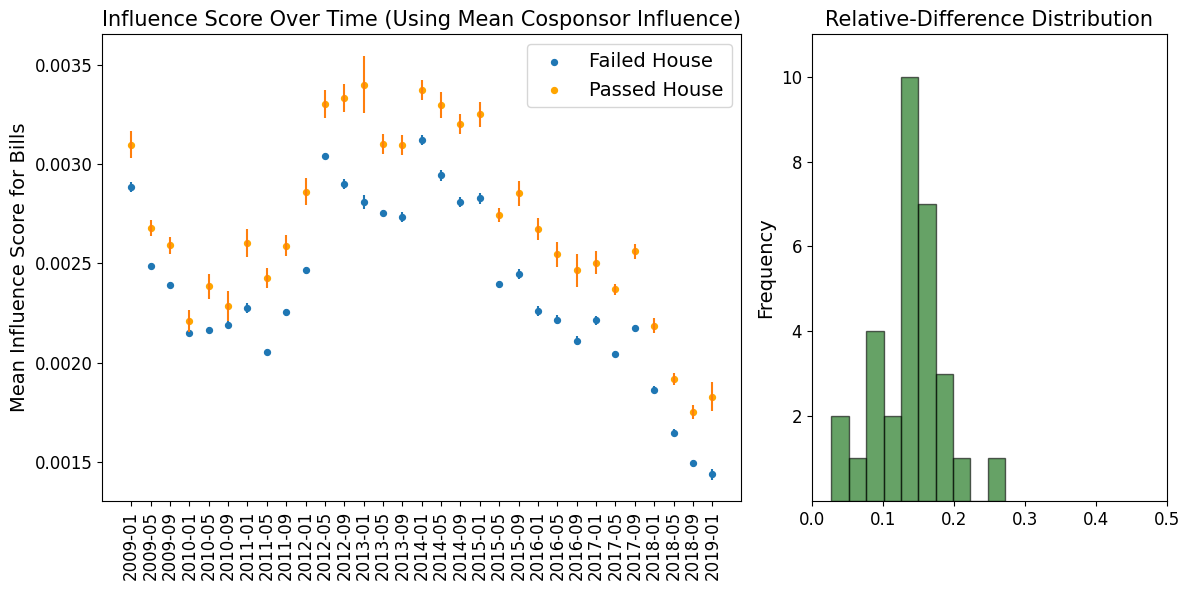

In [11]:
avg_6 = plot_4_month_influence("House", fail_house_avg_bill_6h, "Mean Influence Score for Bills", "Influence Score Over Time (Using Mean Cosponsor Influence)")

In [12]:
avg_6["Percent_Difference"].mean()

0.13869961044053464

<ipython-input-10-62a6fb73c835>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)  # Set x-axis tick labels with rotation and fontsize


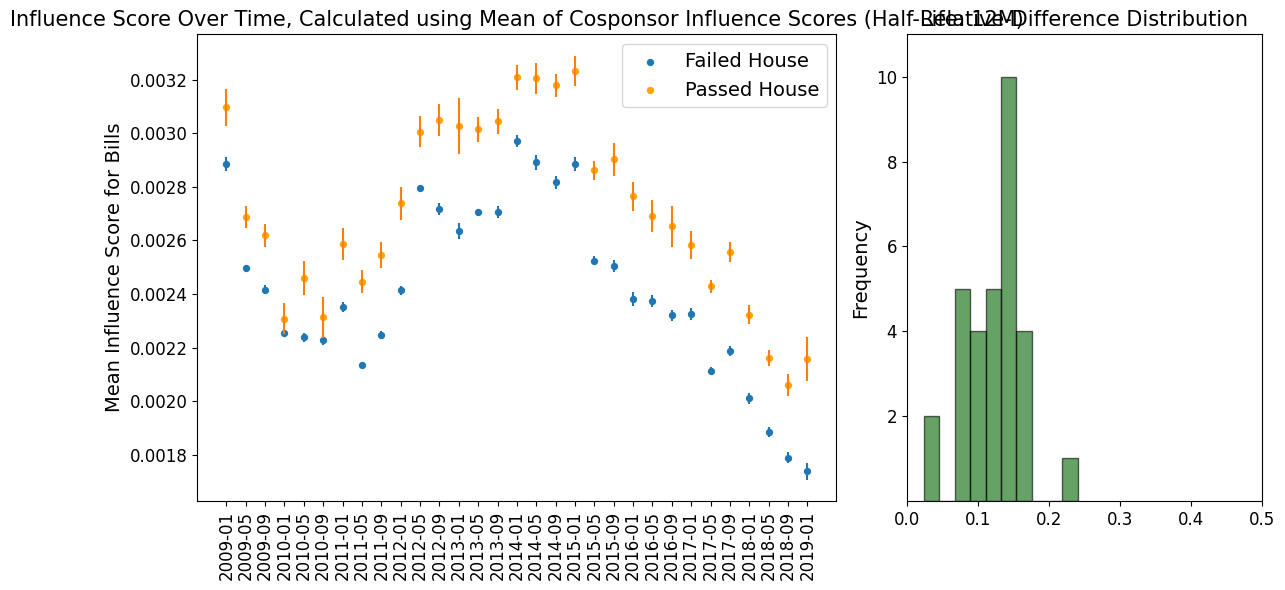

In [13]:
avg_12 = plot_4_month_influence("House", fail_house_avg_bill_12h, "Mean Influence Score for Bills", "Influence Score Over Time HL 12(Using Mean Cosponsor Influence)")

In [14]:
avg_12["Percent_Difference"].mean()

0.12212747542428964

<ipython-input-10-62a6fb73c835>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)  # Set x-axis tick labels with rotation and fontsize


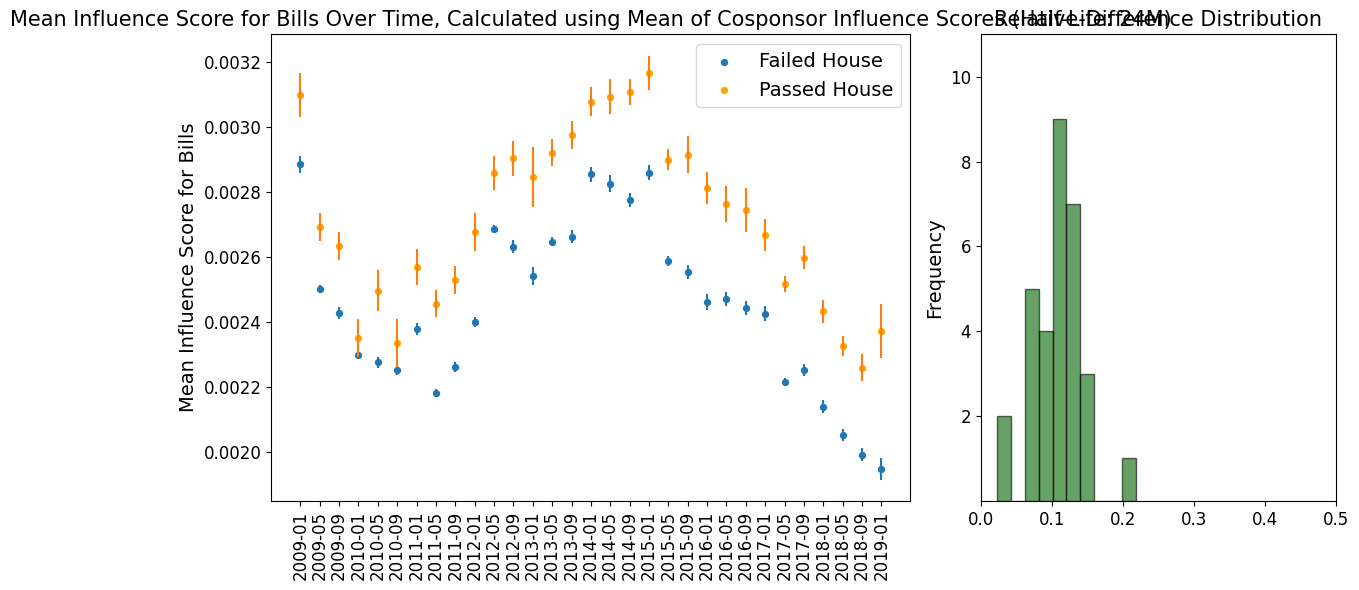

In [15]:
avg_24 = plot_4_month_influence("House", fail_house_avg_bill_24h, "Mean Influence Score for Bills", "Influence Score Over Time HL 24 (Using Mean Cosponsor Influence)")

In [16]:
avg_24["Percent_Difference"].mean()

0.10974040606716999

**Max**

<ipython-input-10-62a6fb73c835>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)  # Set x-axis tick labels with rotation and fontsize


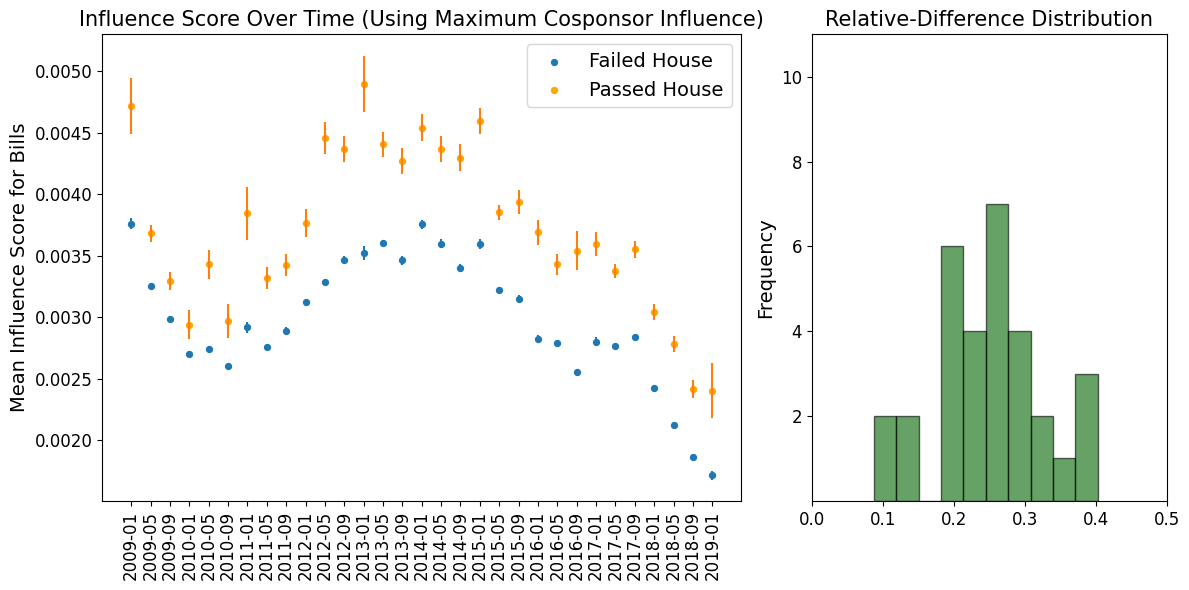

In [17]:
max_6 = plot_4_month_influence("House", fail_house_max_bill_6h, "Mean Influence Score for Bills", "Influence Score Over Time (Using Maximum Cosponsor Influence)")

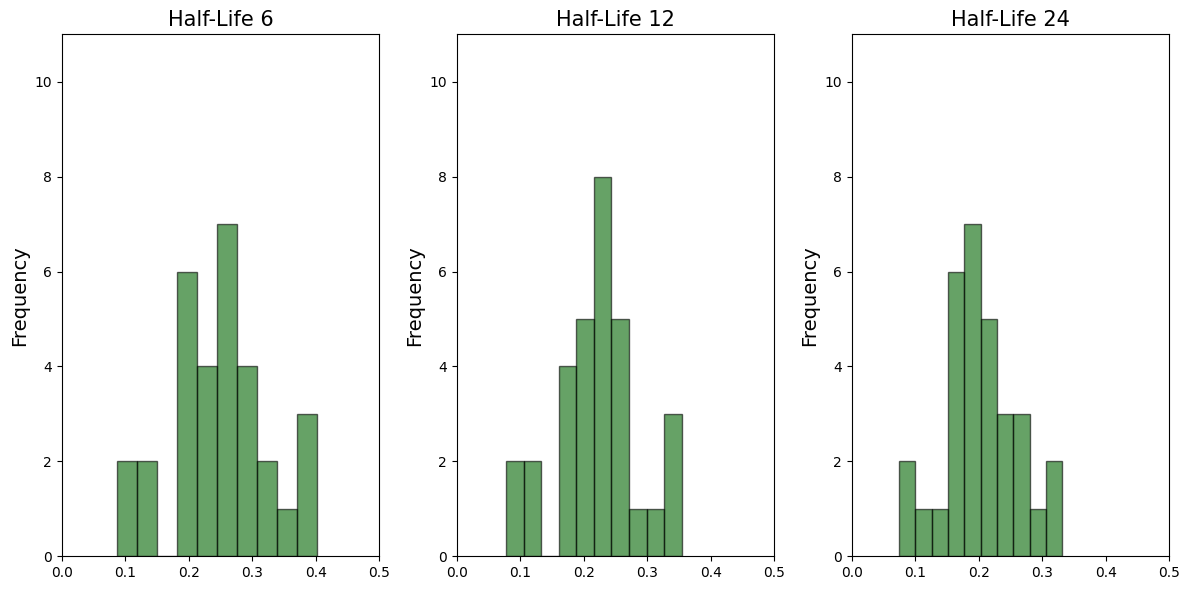

In [18]:
bills_df = [fail_house_max_bill_6h,fail_house_max_bill_12h,fail_house_max_bill_24h]

halflife_values = [6, 12, 24]

# Create a grid of subplots with one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for i, df in enumerate(bills_df):
	halflife = halflife_values[i]
	fail = df[df["Passed"] != 1]
	passed = df[df["Passed"] == 1]

	passed_plot = passed.copy()
	passed_plot["Time"] = passed_plot["Time"].dt.to_timestamp()
	passed_plot = passed_plot.set_index("Time")
	passed_plot = passed_plot.resample("4M").agg({"Influence_Score": ["mean", "std", "count"]})
	passed_plot = passed_plot.reset_index()
	passed_plot.columns = ["Time", "mean", "std", "count"]
	passed_plot["Time"] = passed_plot["Time"].dt.strftime('%Y-%m')
	passed_plot["sqrt_count"] = np.sqrt(passed_plot["count"].to_numpy())
	passed_plot = passed_plot.sort_values("Time")
	passed_plot_sort = passed_plot.sort_values("count")

	failed_plot = fail.copy()
	failed_plot["Time"] = failed_plot["Time"].dt.to_timestamp()
	failed_plot = failed_plot.set_index("Time")
	failed_plot = failed_plot.resample("4M").agg({"Influence_Score": ["mean", "std", "count"]})
	failed_plot = failed_plot.reset_index()
	failed_plot.columns = ["Time", "mean", "std", "count"]
	failed_plot["Time"] = failed_plot["Time"].dt.strftime('%Y-%m')
	failed_plot["sqrt_count"] = np.sqrt(failed_plot["count"].to_numpy())
	failed_plot = failed_plot.sort_values("Time")
	failed_plot_sort = failed_plot.sort_values("count")

	merged_plot = pd.merge(passed_plot, failed_plot, on="Time", suffixes=("_passed", "_failed"))
	merged_plot["Percent_Difference"] = ((merged_plot["mean_passed"] - merged_plot["mean_failed"]) / merged_plot["mean_failed"])

	# Plot the histogram in the current subplot
	ax = axes[i]
	ax.set_xlim([0,0.5])
	ax.set_ylim([0,11])
	ax.hist(merged_plot["Percent_Difference"], bins=10, edgecolor='k', color="darkgreen", alpha=0.6)
	ax.set_title("Half-Life " + str(halflife), fontsize=15)
	ax.set_ylabel("Frequency", fontsize=14)

	# Format x-axis labels with percent signs
	# ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _ : f'{x:.0f}%'))

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

In [19]:
max_6["Percent_Difference"].mean()

0.24846874444012212

<ipython-input-10-62a6fb73c835>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)  # Set x-axis tick labels with rotation and fontsize


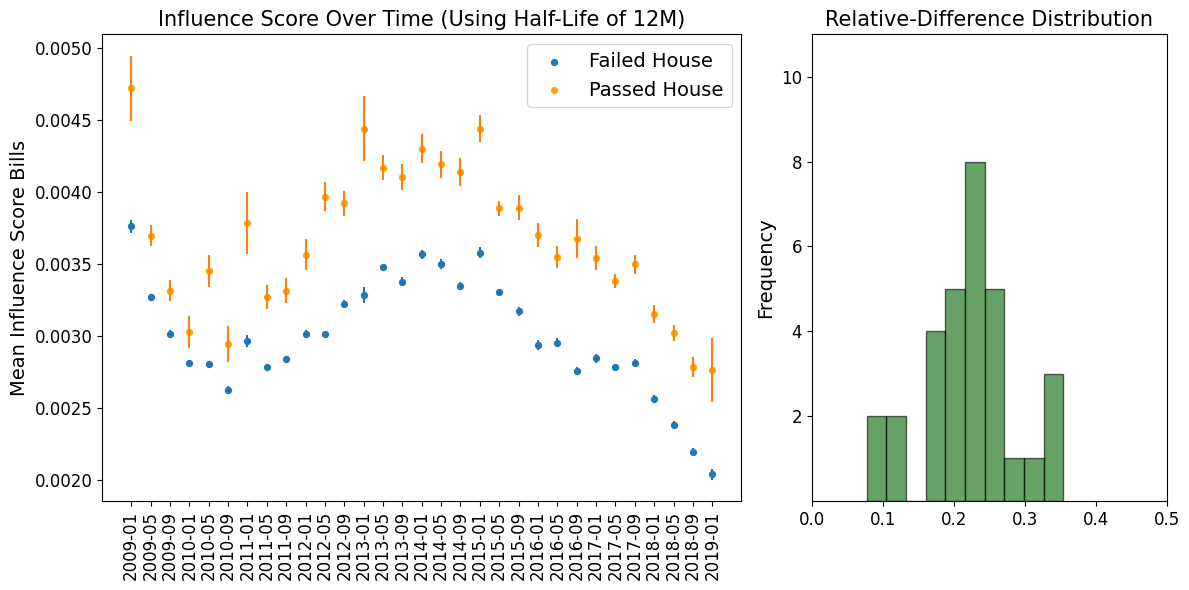

In [20]:
max_12 = plot_4_month_influence("House", fail_house_max_bill_12h, "Mean Influence Score Bills", "Influence Score Over Time HL 12 (Using Maximum Cosponsor Influence)")

In [21]:
max_12["Percent_Difference"].mean()

0.22316647295547337

<ipython-input-10-62a6fb73c835>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)  # Set x-axis tick labels with rotation and fontsize


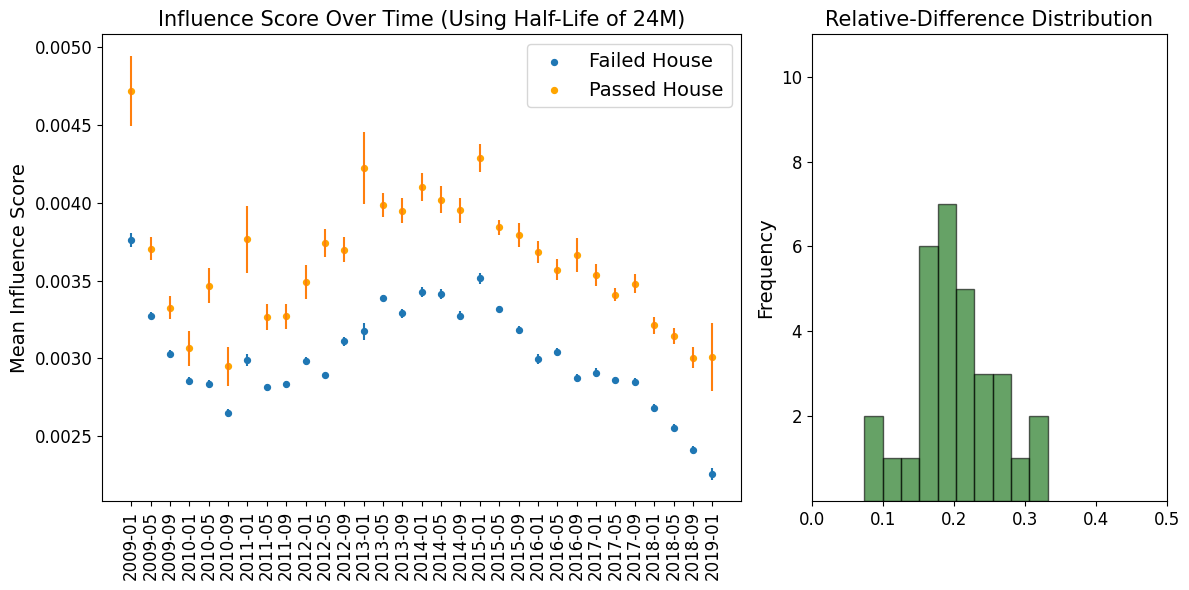

In [22]:
max_24 = plot_4_month_influence("House", fail_house_max_bill_24h, "Mean Influence Score", "Influence Score Over Time HL 24 (Using Maximum Cosponsor Influence)")

In [23]:
max_24["Percent_Difference"].mean()

0.20309723545346942